### Modeling Gaussian Graphical models

We design a synthetic experiment to study the capability of NGMs to represent Gaussian graphical models. The input data X is sampled from a multivariate Gaussian distribution where we define the underlying precision matrix. The graph input G to the NGM will be the corresponding partial correlation matrix. We know that every conditional distribution of a multivariate Gaussian distribution is a Gaussian distribution. The aim of this experiment is to see (via plots) how close are the distributions learned by the NGMs. We additionally gauge the sampling ability of NGMs to model the multivariate Gaussian distribution.

In [1]:
import os, sys
# reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
print(sys.prefix)
import warnings
warnings.filterwarnings('ignore')

import pickle

/home/harshx/anaconda3/envs/ngm


### Setup the Gaussian graphical model
1. Initialize a graph type.
2. Get the precision matrix `theta` and corresponding samples `X` from a multivariate Gaussian distribution.
3. Get the partial correlations matrix `rho` and the graph `G`.

In [61]:
import numpy as np
import pandas as pd

# Local imports
from ngm.utils import ggm
from ngm.utils import data_processing as dp
# from uGLAD.utils.metrics import reportMetrics

# Xb = samples batch, trueTheta = corresponding true precision matrices
Xb, true_theta = ggm.get_data(
    num_nodes=10, 
    typeG='CHAIN', 
    sparsity=[0.2, 0.2], # Not used for chain graph
    num_samples=5000, 
    batch_size=1,
    eig_offset=0.1, 
    w_min=0.5,
    w_max=1
)
X, true_theta =Xb[0], true_theta[0]
# set the column names for X
X = pd.DataFrame(X, columns=['n'+str(i) for i in range(X.shape[1])])
rho = ggm.get_partial_correlations(true_theta)
print(f'partial correlations: {rho.shape}, Samples {X.shape}')
G, image_G, graph_edge_list = ggm.graph_from_partial_correlations(rho, X.columns)

partial correlations: (10, 10), Samples (5000, 10)
Sparsity 1 using threshold 0.0


In [62]:
Gv = dp.get_interactive_graph(G, 'GGM Chain graph', node_PREFIX=None)
Gv.show('viz_ggm.html')

### NGM: Learning

For faster runtimes, set USE_CUDA=True

In [ ]:
import pandas as pd
# import ngm.learning as ngm_learn
import ngm.main as ngm

# Learning the NMG model
model_NGM = ngm.learning(
    G, X, lambd=1e1,
    hidden_dim=30,
    epochs=3000, 
    lr=0.001,
    norm_type='min_max',
    k_fold=1,
    structure_penalty='hadamard'
) 

### Function visualization: Analyse a feature of interest 

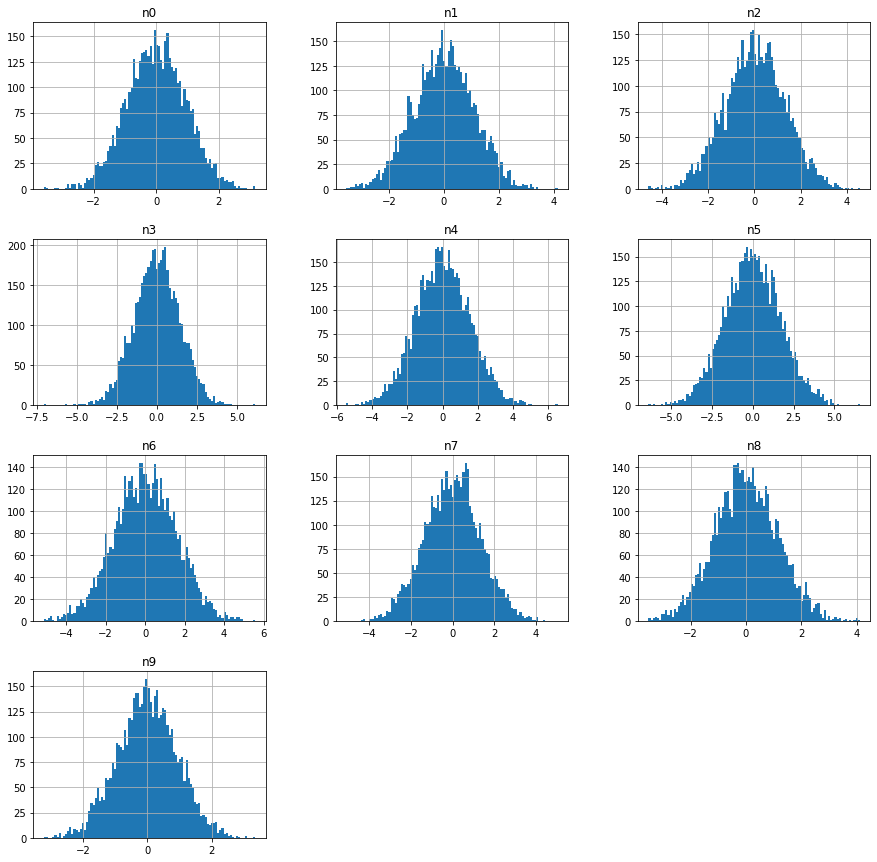

In [88]:
hist = ngm.marginal_distributions(model_NGM, X)
hist
feature_of_interest = 'n5'

#### GGM
Can be shown analytically 

Features dropped from graph: set()
target=n5, source=n4
target=n5, source=n6


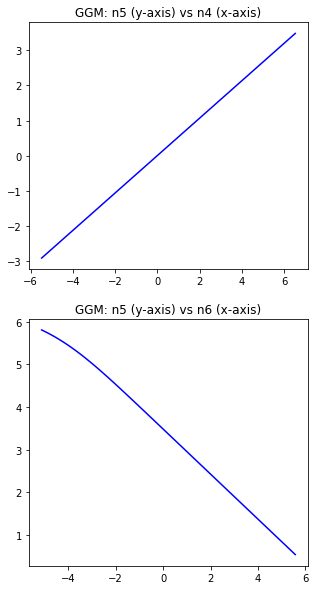

In [86]:
# Local imports
from ngm.utils import ggm

# Define the mean and cov of the multivariate Gaussian
data_min_ = X.min(axis=0)
data_max_ = X.max(axis=0)
_scaler = [data_min_, data_max_]
D = true_theta.shape[0]
mean = pd.Series(np.zeros(D), index=X.columns)
cov=np.linalg.pinv(true_theta)

# Analyse the feature dependency functions
ggm.analyse_feature(feature_of_interest, [mean, cov, _scaler], G, Xi=mean)

#### NGM

Features dropped from graph: set()
target=n5, source=n4
target=n5, source=n6


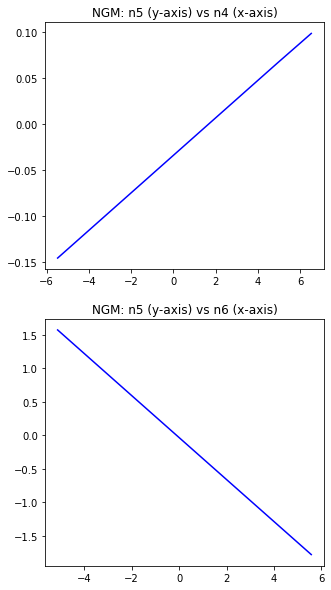

In [87]:
# Analyse the distribution details of the feature of interest
ngm.analyse_feature(feature_of_interest, model_NGM, G, dp.series2df(mean))

### NGM: Sampling

In [ ]:
import ngm.main as ngm

Xs = ngm.sampling(model_NGM, G, num_samples=4000, max_infer_itr=2)
Xs = Xs[X.columns]

### Run CI graph recovery algorithms
1. uGLAD
2. BCD

In [68]:
# uGLAD
from ngm.utils.uGLAD import main as uG
from ngm.utils.metrics import reportMetrics

# Initialize the model
model_uGLAD = uG.uGLAD_GL()  

Xs = Xs[X.columns]
# Fit to the data
model_uGLAD.fit(
    Xs,
    centered=False,
    epochs=2000,
    lr=0.001,
    INIT_DIAG=0,
    L=5,
    verbose=True, 
    k_fold=0,  # Direct mode
    mode='direct'
)  

# Comparing with true precision matrix
compare_theta_uGLAD = reportMetrics(
        true_theta, 
        model_uGLAD.precision_
    )
print(f'uGLAD: {compare_theta_uGLAD}')

Running uGLAD
Processing the input table for basic compatibility check
: Processing the input table for basic compatibility check
: The input table has sample 4000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
Input covariance matrix: The condition number 1.5572058852566435 and min eig 0.006871181005512089 max eig 0.010699843500447085
: Duplicates dropped: total 0, columns []
: Low Variance columns dropped: min variance 0.0,        total 0, columns []
Processed covariance matrix: The condition number 1.5572058852566435 and min eig 0.006871181005512089 max eig 0.010699843500447085
: The processed table has sample 4000 and features 10
: Total time to process the table 0.852 secs
Direct Mode
epoch:0/2000 loss:-12.358485221862793
epoch:200/2000 loss:-15.940261840820312
epoch:400/2000 loss:-20.333969116210938
epoch:600/2000 loss:-25.18743133544922
epoch:800/2000 loss:-37.673797607421875
epoch:1000/2000 loss:-37.6756591796875
epoch:1200/20

In [82]:
def viz_graph_from_precision(theta):
    rho = ggm.get_partial_correlations(theta)
    Gr, _, _ = ggm.graph_from_partial_correlations(
        rho, 
        Xs.columns,
        sparsity=0.3
    )
    Gv = dp.get_interactive_graph(Gr, 'CI graph recovered from NGM samples', node_PREFIX=None)
    return Gv
    

In [83]:
Gv = viz_graph_from_precision(model_uGLAD.precision_)
Gv.show('viz_ggm_from_ngm_samples.html')

Sparsity 0.3 using threshold 0.05290000024270138
